In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 300
train_conf

{'num_epochs': 300, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'basic_lr1e-3_epoch300_resnet50_encoder'
data_conf

{'conf_name': 'basic_lr1e-3_epoch300_resnet50_encoder',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test': (slice(None, None, None),
    slice(None,

In [9]:
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet50',
 'encoder_weights': 'imagenet'}

In [10]:
optimizer_config['opt_type'] = 'SGD'
optimizer_config['lr'] = 1e-3
optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'SGD',
 'lr': 0.001,
 'weight_decay': 0.0001,
 'amsgrad': False,
 'nesterov': True,
 'momentum': 0.9,
 'centered': False}

In [11]:
loss_config =[
    {'loss': 'BCE', 'weight': 1, 'params': {}},
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {}}]

In [12]:
data_conf['patches']

{'train': (128, 128, 1), 'val': (128, 128, 1), 'test': (128, 128, 1)}

## Prepare train, validation and test data

In [13]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 528.26it/s]
100%|██████████| 720/720 [00:08<00:00, 86.48it/s]
8280it [00:00, 185704.78it/s]
7920it [00:00, 161857.81it/s]
700it [00:01, 679.50it/s]
100%|██████████| 700/700 [00:07<00:00, 93.21it/s] 
8280it [00:00, 179926.31it/s]
7920it [00:00, 174673.53it/s]
710it [00:01, 661.01it/s]
100%|██████████| 710/710 [00:07<00:00, 89.30it/s]
7920it [00:00, 67704.53it/s]
7560it [00:00, 181091.49it/s]
720it [00:01, 651.30it/s]
100%|██████████| 720/720 [00:08<00:00, 85.99it/s]
8280it [00:00, 181190.78it/s]
720it [00:01, 661.84it/s]
100%|██████████| 720/720 [00:08<00:00, 88.76it/s]
25920it [00:00, 95743.08it/s]
700it [00:01, 682.63it/s]
100%|██████████| 700/700 [00:07<00:00, 93.54it/s] 
25200it [00:00, 89558.78it/s] 
509it [00:00, 916.48it/s]
100%|██████████| 509/509 [00:02<00:00, 182.28it/s]
8144it [00:00, 154532.18it/s]
700it [00:01, 675.18it/s]
100%|██████████| 700/700 [00:07<00:00, 94.01it/s] 
25200it [00:00, 145290.23it/s]
700it [00:01, 497.19it/s]
100%|██████████| 700/700 [00:07

In [14]:
len(data_train), len(data_val), len(data_test)

(24480, 23400, 11)

In [15]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=None,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [16]:
device = 'cuda:1'
# device = 'cpu'

In [17]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [18]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [19]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [20]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.059749


100%|██████████| 732/732 [00:33<00:00, 21.75it/s]


Mean val loss: 0.049033


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 2...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.042342


100%|██████████| 732/732 [00:33<00:00, 21.56it/s]


Mean val loss: 0.03729


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 3...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034301


100%|██████████| 732/732 [00:34<00:00, 21.48it/s]


Mean val loss: 0.031126


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 4...


  3%|▎         | 20/765 [00:03<01:40,  7.40it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [00:35<00:00, 20.35it/s]


Mean val loss: 0.019544


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 12...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01987


100%|██████████| 732/732 [00:35<00:00, 20.60it/s]


Mean val loss: 0.018953


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 13...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019492


100%|██████████| 732/732 [00:35<00:00, 20.46it/s]


Mean val loss: 0.018605


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 14...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019103


 73%|███████▎  | 534/732 [00:25<00:09, 21.14it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017077
EarlyStopping counter: 1 out of 10
Epoch 22...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017233


100%|██████████| 732/732 [00:36<00:00, 19.89it/s]


Mean val loss: 0.01668


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 23...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017097


100%|██████████| 732/732 [00:36<00:00, 20.32it/s]


Mean val loss: 0.01655


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 24...


 59%|█████▊    | 449/765 [00:57<00:41,  7.53it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01598


100%|██████████| 732/732 [00:36<00:00, 20.06it/s]


Mean val loss: 0.015511


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 33...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015909


100%|██████████| 732/732 [00:36<00:00, 20.01it/s]


Mean val loss: 0.015414


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 34...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015766


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015522
EarlyStopping counter: 1 out of 10
Epoch 35...


 50%|████▉     | 379/765 [00:48<00:50,  7.57it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015131


100%|██████████| 732/732 [00:31<00:00, 23.03it/s]


Mean val loss: 0.01487


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 44...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015141


100%|██████████| 732/732 [00:31<00:00, 23.23it/s]


Mean val loss: 0.014772


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 45...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015096


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014894
EarlyStopping counter: 1 out of 10
Epoch 46...


 48%|████▊     | 368/765 [00:44<00:46,  8.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014694


 33%|███▎      | 245/732 [00:10<00:20, 23.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014616


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014464
EarlyStopping counter: 2 out of 10
Epoch 56...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014554


100%|██████████| 732/732 [00:31<00:00, 22.93it/s]


Mean val loss: 0.014321


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 57...


 30%|██▉       | 227/765 [00:27<01:04,  8.31it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [00:31<00:00, 23.24it/s]


Mean val loss: 0.014132


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 64...


 84%|████████▍ | 644/765 [01:16<00:14,  8.49it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014218
EarlyStopping counter: 2 out of 10
Epoch 66...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014265


100%|██████████| 732/732 [00:31<00:00, 22.95it/s]


Mean val loss: 0.014053


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 67...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014239


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014281
EarlyStopping counter: 1 out of 10
Epoch 68...


  1%|▏         | 10/765 [00:01<01:50,  6.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014061


 82%|████████▏ | 597/732 [00:25<00:05, 23.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014087


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013973
EarlyStopping counter: 1 out of 10
Epoch 76...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01399


100%|██████████| 732/732 [00:31<00:00, 23.31it/s]


Mean val loss: 0.013866


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 77...


 17%|█▋        | 132/765 [00:16<01:13,  8.58it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013828


100%|██████████| 732/732 [00:31<00:00, 23.16it/s]


Mean val loss: 0.013757


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 84...


 78%|███████▊  | 598/765 [01:11<00:19,  8.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01379


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013992
EarlyStopping counter: 1 out of 10
Epoch 86...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013764


100%|██████████| 732/732 [00:31<00:00, 23.32it/s]


Mean val loss: 0.013676


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 87...


 93%|█████████▎| 711/765 [01:25<00:06,  8.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013634


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013622
EarlyStopping counter: 2 out of 10
Epoch 95...


 26%|██▌       | 196/765 [00:24<01:09,  8.22it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013611


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013781
EarlyStopping counter: 1 out of 10
Epoch 97...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013563


100%|██████████| 732/732 [00:31<00:00, 23.08it/s]


Mean val loss: 0.013496


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 98...


 47%|████▋     | 361/765 [00:43<00:47,  8.50it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013566
EarlyStopping counter: 2 out of 10
Epoch 105...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013437


 43%|████▎     | 312/732 [00:13<00:17, 24.24it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013346


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013445
EarlyStopping counter: 1 out of 10
Epoch 108...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01336


 94%|█████████▎| 686/732 [00:29<00:01, 23.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013336


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013374
EarlyStopping counter: 2 out of 10
Epoch 114...


 85%|████████▌ | 652/765 [01:18<00:13,  8.21it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [00:31<00:00, 23.20it/s]


Mean val loss: 0.013332


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 116...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013285


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013347
EarlyStopping counter: 1 out of 10
Epoch 117...


 30%|██▉       | 229/765 [00:27<01:02,  8.64it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013458
EarlyStopping counter: 1 out of 10
Epoch 119...


 79%|███████▉  | 605/765 [01:12<00:18,  8.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013138


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013433
EarlyStopping counter: 3 out of 10
Epoch 125...


 58%|█████▊    | 447/765 [00:53<00:36,  8.62it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013388
EarlyStopping counter: 5 out of 10
Epoch 127...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013105


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013416
EarlyStopping counter: 6 out of 10
Epoch 128...


 17%|█▋        | 131/765 [00:16<01:14,  8.51it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [00:31<00:00, 23.15it/s]


Mean val loss: 0.013193


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 130...


 76%|███████▌  | 582/765 [01:09<00:21,  8.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013185
EarlyStopping counter: 3 out of 10
Epoch 136...


 64%|██████▍   | 490/765 [00:58<00:32,  8.53it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013177
EarlyStopping counter: 5 out of 10
Epoch 138...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01296


100%|██████████| 732/732 [00:31<00:00, 23.19it/s]


Mean val loss: 0.013124


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 139...


 16%|█▌        | 119/765 [00:14<01:14,  8.72it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013144
EarlyStopping counter: 1 out of 10
Epoch 141...


 79%|███████▉  | 606/765 [01:12<00:18,  8.52it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012892


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013094
EarlyStopping counter: 1 out of 10
Epoch 147...


 65%|██████▍   | 497/765 [00:59<00:31,  8.57it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [00:31<00:00, 23.11it/s]


Mean val loss: 0.013052


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 149...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012884


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013141
EarlyStopping counter: 1 out of 10
Epoch 150...


 25%|██▌       | 192/765 [00:23<01:11,  8.05it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013506
EarlyStopping counter: 1 out of 10
Epoch 152...


 84%|████████▍ | 644/765 [01:17<00:13,  8.67it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012805


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012984
EarlyStopping counter: 1 out of 10
Epoch 158...


 70%|██████▉   | 534/765 [01:04<00:27,  8.49it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [00:31<00:00, 23.07it/s]


Mean val loss: 0.012946


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 160...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012715


100%|██████████| 732/732 [00:31<00:00, 22.98it/s]


Mean val loss: 0.012935


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 161...


 34%|███▍      | 259/765 [00:31<00:58,  8.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013044
EarlyStopping counter: 2 out of 10
Epoch 163...


 83%|████████▎ | 635/765 [01:16<00:15,  8.47it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012642


100%|██████████| 732/732 [00:31<00:00, 23.24it/s]


Mean val loss: 0.012885


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 169...


 29%|██▉       | 221/765 [00:26<01:03,  8.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012651


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012908
EarlyStopping counter: 2 out of 10
Epoch 171...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012618


 72%|███████▏  | 528/732 [00:23<00:08, 25.10it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01262


100%|██████████| 732/732 [00:31<00:00, 23.02it/s]


Mean val loss: 0.012869


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 174...


 44%|████▎     | 334/765 [00:40<00:49,  8.67it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012568


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012915
EarlyStopping counter: 5 out of 10
Epoch 180...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012515


100%|██████████| 732/732 [00:31<00:00, 23.06it/s]


Mean val loss: 0.012791


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 181...


 79%|███████▉  | 606/765 [01:12<00:18,  8.50it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012526


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012945
EarlyStopping counter: 2 out of 10
Epoch 183...


 13%|█▎        | 97/765 [00:12<01:18,  8.53it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012445


100%|██████████| 732/732 [00:31<00:00, 22.96it/s]


Mean val loss: 0.012745


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 191...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012466


100%|██████████| 732/732 [00:31<00:00, 23.15it/s]


Mean val loss: 0.012754


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 192...


 75%|███████▌  | 576/765 [01:08<00:23,  8.00it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012444


100%|██████████| 732/732 [00:31<00:00, 23.48it/s]


Mean val loss: 0.012731


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 194...


  6%|▋         | 49/765 [00:06<01:23,  8.53it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012361


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01271
EarlyStopping counter: 1 out of 10
Epoch 202...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012368


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01271
EarlyStopping counter: 2 out of 10
Epoch 203...


 47%|████▋     | 362/765 [00:43<00:49,  8.10it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012333


 54%|█████▎    | 392/732 [00:16<00:13, 24.62it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012279


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012708
EarlyStopping counter: 2 out of 10
Epoch 213...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012283


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012661
EarlyStopping counter: 3 out of 10
Epoch 214...


 54%|█████▍    | 416/765 [00:49<00:40,  8.62it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012285


 54%|█████▍    | 394/732 [00:16<00:14, 23.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012224


100%|██████████| 732/732 [00:31<00:00, 23.57it/s]


Mean val loss: 0.012603


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 224...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012192


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012648
EarlyStopping counter: 1 out of 10
Epoch 225...


 59%|█████▉    | 450/765 [00:53<00:39,  7.92it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012176


 71%|███████▏  | 523/732 [00:22<00:08, 24.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012137


100%|██████████| 732/732 [00:31<00:00, 23.29it/s]


Mean val loss: 0.01251


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 235...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012127


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012528
EarlyStopping counter: 1 out of 10
Epoch 236...


 54%|█████▍    | 415/765 [00:49<00:40,  8.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01214


 76%|███████▌  | 556/732 [00:23<00:07, 24.40it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012077


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012572
EarlyStopping counter: 1 out of 10
Epoch 246...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012064


100%|██████████| 732/732 [00:31<00:00, 23.51it/s]


Mean val loss: 0.01248


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 247...


 60%|██████    | 459/765 [00:54<00:36,  8.29it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012045


 79%|███████▊  | 576/732 [00:24<00:06, 24.18it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012025


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012447
EarlyStopping counter: 1 out of 10
Epoch 257...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012019


100%|██████████| 732/732 [00:31<00:00, 23.49it/s]


Mean val loss: 0.01242


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 258...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011989


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012502
EarlyStopping counter: 1 out of 10
Epoch 259...


 13%|█▎        | 99/765 [00:12<01:19,  8.40it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011976


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012472
EarlyStopping counter: 5 out of 10
Epoch 265...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011974


100%|██████████| 732/732 [00:31<00:00, 23.34it/s]


Mean val loss: 0.012382


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 266...


 37%|███▋      | 283/765 [00:33<00:55,  8.62it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012402
EarlyStopping counter: 2 out of 10
Epoch 269...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011936


100%|██████████| 732/732 [00:30<00:00, 23.65it/s]


Mean val loss: 0.012374


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 270...


  8%|▊         | 59/765 [00:07<01:22,  8.51it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011914


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012372
EarlyStopping counter: 1 out of 10
Epoch 276...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011919


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01238
EarlyStopping counter: 2 out of 10
Epoch 277...


 33%|███▎      | 254/765 [00:30<00:59,  8.64it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012418
EarlyStopping counter: 1 out of 10
Epoch 280...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011884


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012368
EarlyStopping counter: 2 out of 10
Epoch 281...


  4%|▍         | 34/765 [00:04<01:27,  8.32it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011882


100%|██████████| 732/732 [00:30<00:00, 23.69it/s]


Mean val loss: 0.012315


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 287...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011861


100%|██████████| 732/732 [00:31<00:00, 23.49it/s]


Mean val loss: 0.012303


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 288...


 28%|██▊       | 214/765 [00:25<01:02,  8.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012323
EarlyStopping counter: 3 out of 10
Epoch 291...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011847


100%|██████████| 732/732 [00:31<00:00, 23.47it/s]


Mean val loss: 0.012301


  0%|          | 0/765 [00:00<?, ?it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011826


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012338
EarlyStopping counter: 2 out of 10
Epoch 298...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01181


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012264
Epoch 299...


 21%|██        | 160/765 [00:19<01:09,  8.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 16%|█▋        | 129/788 [01:20<06:44,  1.63it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Dump experiment results

In [21]:
import pickle
import json

In [22]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [23]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [24]:
from itertools import chain

In [25]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [26]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

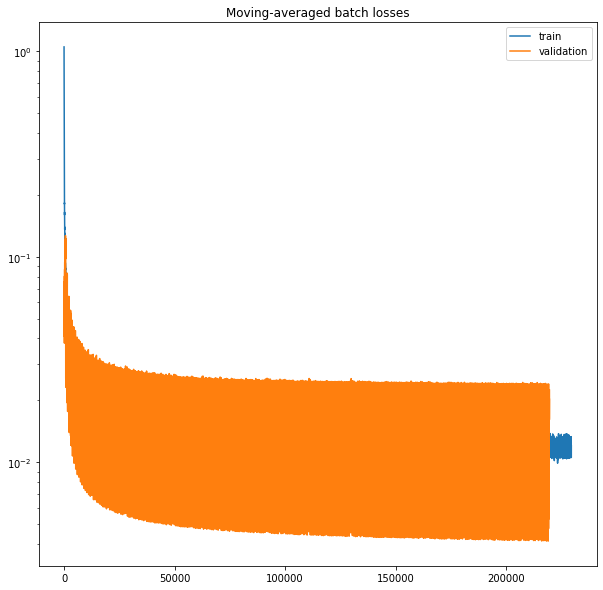

In [27]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [28]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

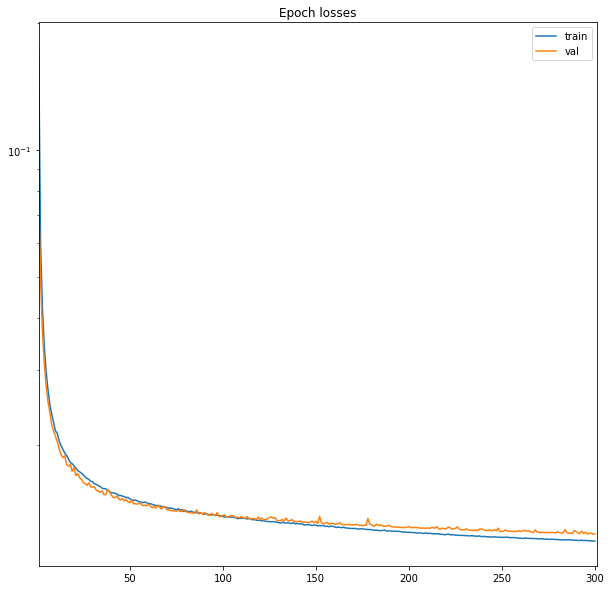

In [29]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [30]:
import pandas as pd

In [31]:
from visualization_utils import make_df

In [32]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.996129,0.976256,0.974423,0.975339,0.998141,0.951864,carb96558,basic
1,0.988472,0.920659,0.987226,0.952781,0.994635,0.909821,carb71,basic
2,0.981937,0.956734,0.840461,0.894836,0.976133,0.809686,carbRNF,basic
3,0.991016,0.998327,0.907272,0.950624,0.998133,0.905894,SPE_carb10_58_box3,basic
4,0.992157,0.984844,0.877999,0.928357,0.991003,0.866294,SoilAh-1,basic
5,0.996803,0.968284,0.962545,0.965406,0.996244,0.933126,SoilB-2,basic
6,0.989367,0.996631,0.913436,0.953222,0.997464,0.910624,TeTree_subset1,basic
7,0.993042,0.996799,0.934046,0.964403,0.998446,0.931253,TiTree_subset2,basic
8,0.991834,0.971081,0.965848,0.968457,0.996957,0.938844,Urna_22,basic
9,0.990527,0.976098,0.971299,0.973693,0.997976,0.948734,Urna_30,basic


In [33]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.91079
Std    IOU: 0.041305
Min    IOU: 0.80969
Median IOU: 0.91256
